# Introdução

O [Rate Your Music](https://rateyourmusic.com/) é uma comunidade online para fãs de música e também serve como um excelente catálogo de músicas. Hipsters de todas as idades amam esse site, e não é por acaso. Há diversas formas para descobrir e conhecer músicas e artistas novos dentro do site. E isso é o que faz dele interessante e tão utilizado.

Pessoalmente, gosto como os gêneros são bem detalhados para cada álbum e são dados diversos "descritores" para eles: se o álbum é ritmico, se é introspectivo, depressivo, animado e tantos outros.

Raspando os dados do site, combinei o chart de top 1000 álbuns entre os anos de 2010 e 2021 e vamos tentar prever a avaliação dos albuns usando seus atributos.

# Leitura dos Dados

Vamos começar importando os pacotes necessários para a análise.

In [203]:
from glob import glob
import re
from collections import Counter

import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer

from scipy.stats import uniform
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

E vamos treinar o modelo usando os anos de 2010 a 2019 para prever a avaliação dos albuns de 2020 e 2021.

In [117]:
rym_train = pd.concat([pd.read_csv(file) for file in glob("./data/*.csv") if not bool(re.search("2020|2021", file))])
rym_test = pd.concat([pd.read_csv(file) for file in glob("./data/*csv") if bool(re.search("2020|2021", file))])

Podemos observar as primeiras linhas dos dados e as informações sobre suas colunas.

In [118]:
rym_train.head()

,position,artist,album,release_date,primary_genres,secondary_genres,descriptors,number_ratings,number_reviews,avg_rating,id_spotify
0,1,Kanye West,My Beautiful Dark Twisted Fantasy,22 November 2010,"Pop Rap, Hip Hop",Art Pop,"epic, boastful, passionate, sampling, hedonist...","55,470",663.0,4.09,20r762YmB5HeofjMCiPMLv
1,2,Joanna Newsom,Have One on Me,23 February 2010,"Chamber Folk, Singer-Songwriter, Progressive Folk",NaN,"poetic, pastoral, warm, passionate, lush, comp...","10,084",221.0,3.96,NaN
2,3,The Brave Little Abacus,Just Got Back From the Discomfort—We're Alright,29 May 2010,"Midwest Emo, Experimental Rock","Math Rock, Post-Hardcore, Art Rock","passionate, bittersweet, introspective, uncomm...","9,237",124.0,3.87,3jLrWEYpwKnptkzEXAyT66
3,4,Flying Lotus,Cosmogramma,3 May 2010,"IDM, Glitch Hop, Wonky","Nu Jazz, Instrumental Hip Hop, Wonky","futuristic, space, chaotic, rhythmic, instrume...","19,608",167.0,3.83,5c7XChrHxYaqykCZLaGM5f
4,5,LCD Soundsystem,This Is Happening,18 May 2010,"Dance-Punk, Indietronica","Alternative Dance, New Wave, Electro-Disco, Ne...","sarcastic, rhythmic, energetic, repetitive, ma...","16,823",190.0,3.83,4hnqM0JK4CM1phwfq1Ldyz


In [119]:
rym_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          10000 non-null  int64  
 1   artist            10000 non-null  object 
 2   album             10000 non-null  object 
 3   release_date      10000 non-null  object 
 4   primary_genres    10000 non-null  object 
 5   secondary_genres  8898 non-null   object 
 6   descriptors       9269 non-null   object 
 7   number_ratings    10000 non-null  object 
 8   number_reviews    9747 non-null   float64
 9   avg_rating        10000 non-null  float64
 10  id_spotify        9269 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 937.5+ KB


Temos 10 mil observações, a partir do top 1000 dos anos de 2010 a 2019.

`number_ratings` é uma variável numérica mas está como string.

Antes da análise exploratória vamos substituir os valores nulos existentes no banco. Tem valores nulos nas colunas `secondary_genres`, `descriptors`, `number_reviews` e `id_spotify`. Essa última coluna não será utilizada aqui pois ela é somente um identificador, não trazendo nenhuma informação em si. Os valores nulos em `secondary_genres` e `descriptors` serão substituidos, respectivamente, para "no secondary genre" e "no descriptors", e `number_reviews` substituiremos os nulos com 0 (valores nulos significam apenas que não houve reviews no album).

In [120]:
rym_train["number_ratings"] = rym_train["number_ratings"].apply(lambda x: x.replace(",", "")).astype("float")

In [121]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [122]:
alt.Chart(rym_train).mark_bar().encode(
    x=alt.X("avg_rating:Q", bin=alt.Bin(step=0.1)),
    y="count()"
)

alt.Chart(...)

In [123]:
plt1 = alt.Chart(rym_train).mark_circle().encode(
    x="number_ratings:Q",
    y=alt.Y("avg_rating:Q", scale=alt.Scale(domain=[2.9, 4.4])),
    tooltip=['artist', 'album', "release_date"]
)

plt2 = alt.Chart(rym_train).mark_circle().encode(
    x="number_reviews:Q",
    y=alt.Y("avg_rating:Q", scale=alt.Scale(domain=[2.9, 4.4])),
    tooltip=['artist', 'album', "release_date"]
)

alt.hconcat(plt1, plt2).configure_mark(opacity=0.3)

alt.HConcatChart(...)

Tanto `number_ratings` quanto `number_reviews` parecem ter uma relação positiva com `avg_rating`, apesar de ser uma relação mais frágil levada mais pelos outliers. Além disso ambas as variáveis parecem ser redundantes, o que sugere que seja melhor remover uma das variáveis.

In [124]:
def tokenizer_comma(string):
    return string.split(", ")

def plot_wordcloud(df, col):
    values = []
    for val in df[col].dropna():
        values += tokenizer_comma(val)
    val_freq = Counter(values)
    wc = WordCloud(background_color="white", width=1169, height=700).generate_from_frequencies(val_freq)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    plt.show()

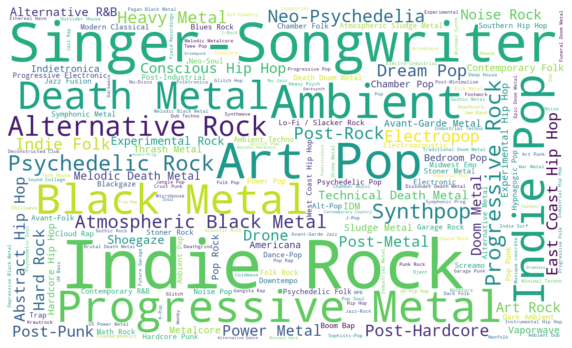

In [125]:
plot_wordcloud(rym_train, "primary_genres")

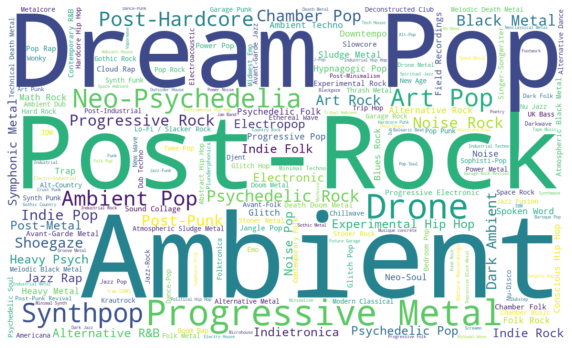

In [126]:
plot_wordcloud(rym_train, "secondary_genres")

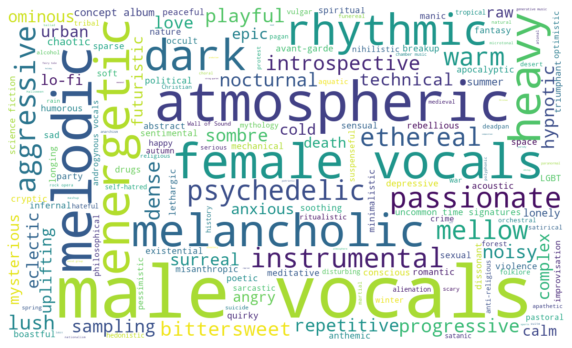

In [127]:
plot_wordcloud(rym_train, "descriptors")

In [128]:
rym_train.reset_index(drop=True)["descriptors"][0]

'epic, boastful, passionate, sampling, hedonistic, anthemic, vulgar, male vocals'

In [129]:
teste = rym_train.reset_index(drop=True)["descriptors"].dropna()

In [130]:
teste

0       epic, boastful, passionate, sampling, hedonist...
1       poetic, pastoral, warm, passionate, lush, comp...
2       passionate, bittersweet, introspective, uncomm...
3       futuristic, space, chaotic, rhythmic, instrume...
4       sarcastic, rhythmic, energetic, repetitive, ma...
                              ...                        
9995    acoustic, calm, male vocals, melodic, melancholic
9996    bittersweet, lush, sentimental, warm, happy, d...
9997      raw, male vocals, history, philosophical, heavy
9998    male vocals, atmospheric, mysterious, nocturna...
9999    minimalistic, suspenseful, cold, ethereal, lus...
Name: descriptors, Length: 9269, dtype: object

In [131]:
rym_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          10000 non-null  int64  
 1   artist            10000 non-null  object 
 2   album             10000 non-null  object 
 3   release_date      10000 non-null  object 
 4   primary_genres    10000 non-null  object 
 5   secondary_genres  8898 non-null   object 
 6   descriptors       9269 non-null   object 
 7   number_ratings    10000 non-null  float64
 8   number_reviews    9747 non-null   float64
 9   avg_rating        10000 non-null  float64
 10  id_spotify        9269 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.2+ MB


In [133]:
rym_train["secondary_genres"] = rym_train["secondary_genres"].fillna("No Secondary Genre")
rym_train["descriptors"] = rym_train["descriptors"].fillna("No Descriptor")
rym_train["number_reviews"] = rym_train["number_reviews"].fillna(0)

In [152]:
def get_bag_of_words(df, col):
    vect = CountVectorizer(tokenizer=tokenizer_comma)
    
    bag = vect.fit_transform(df[col]).toarray()
    bag_names = [f"{col}_{name}" for name in vect.get_feature_names_out()]
    return pd.DataFrame(data=bag, columns=bag_names)

In [159]:
rym_X_tr = pd.concat([get_bag_of_words(rym_train, col) for col in ["primary_genres", "secondary_genres", "descriptors"]], axis=1)

rym_y_tr = rym_train["avg_rating"]

In [199]:
lasso = LassoCV()

In [205]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import numpy as np

In [215]:
grid_lasso = {
    "alpha": uniform(loc=0, scale=20)
}

lasso = Lasso()

teste = RandomizedSearchCV(lasso, grid_lasso, cv=10, n_jobs=-1, random_state=42, scoring="neg_mean_squared_error")

In [216]:
teste.fit(rym_X_tr, rym_y_tr)

RandomizedSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000221021BEBB0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [226]:
rym_X_tr.columns.shape

(1762,)

In [224]:
teste.best_estimator_.coef_.shape

(1762,)

In [229]:
pd.DataFrame(data=zip(rym_X_tr.columns, teste.best_estimator_.coef_), columns=["feature", "coef"]).sort_values("coef", ascending=True)

,feature,coef
0,primary_genres_a cappella,-0.0
1180,secondary_genres_liquid drum and bass,-0.0
1179,secondary_genres_lieder,0.0
1178,secondary_genres_library music,0.0
1177,secondary_genres_latin soul,0.0
...,...,...
582,primary_genres_sound collage,0.0
581,primary_genres_soul,0.0
580,primary_genres_sophisti-pop,0.0
591,primary_genres_southern soul,0.0


In [218]:
np.sqrt(-teste.best_score_)

0.15665768719735618

In [202]:
lasso.score(rym_X_tr, rym_y_tr)

0.25463923457650695

In [193]:
teste = cross_val_score(RandomForestRegressor(), rym_X_tr, rym_y_tr, cv=10, scoring="neg_mean_squared_error")

np.sqrt(np.mean(-teste))

0.14461309559263294

In [176]:
teste = rym_train.copy()
teste["pred"] = np.mean(rym_train["avg_rating"])

In [178]:
teste["error_sq"] = (teste["avg_rating"] - teste["pred"])**2

In [181]:
np.sqrt(np.mean(teste["error_sq"]))

0.15662066529037602

In [195]:
0.14461309559263294 / 0.15662066529037602

0.9233334268151591

In [194]:
0.14293570826470295 / 0.15662066529037602

0.9126235544951807

In [197]:
0.1471063221078874 / 0.15662066529037602

0.9392523128103885

In [ ]:
lasso.fit(rym_X_tr, rym_y_tr)

In [144]:
sc_genres_bag_names

681

In [145]:
descriptors_bag_names

array(['a cappella', 'abstract', 'acoustic', 'aggressive', 'alcohol',
       'aleatory', 'alienation', 'anarchism', 'androgynous vocals',
       'angry', 'anthemic', 'anti-religious', 'anxious', 'apathetic',
       'apocalyptic', 'aquatic', 'atmosphere', 'atmospheric', 'atonal',
       'autumn', 'avant-garde', 'ballad', 'bittersweet', 'boastful',
       'breakup', 'calm', 'chamber music', 'chaotic', 'choral',
       'christian', 'christmas', 'cold', 'complex', 'composition',
       'concept album', 'conscious', 'crime', 'cryptic', 'dark',
       'deadpan', 'death', 'dense', 'depressive', 'desert', 'dissonant',
       'disturbing', 'drugs', 'eclectic', 'educational', 'energetic',
       'ensemble', 'epic', 'ethereal', 'existential', 'fairy tale',
       'fantasy', 'female vocals', 'folklore', 'forest', 'funereal',
       'futuristic', 'generative music', 'halloween', 'happy', 'hateful',
       'heavy', 'hedonistic', 'history', 'holiday', 'humorous', 'hymn',
       'hypnotic', 'ideology'

In [68]:
rym_train["secondary_genres"].values.shape

(10000,)

In [111]:
pipe_secondary_genre.fit_transform(rym_train["descriptors"].values.reshape(-1, 1))

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [37]:
transf_col.get_feature_names_out()

array(['impute_nulls__secondary_genres', 'impute_nulls__descriptors'],
      dtype=object)

In [90]:
vect = CountVectorizer(tokenizer=tokenizer_comma)

In [105]:
vect = CountVectorizer(token_pattern=r"\b\w[\s?\-?\w]+\b")

In [106]:
pd.DataFrame(vect.fit_transform(teste).toarray())

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9264,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
com_reg = vect.get_feature_names()

C:\Users\Silas\Projetos\rym-rating-prediction\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [93]:
com_func = vect.get_feature_names()

In [99]:
len(com_func)

197

In [108]:
len(com_reg)

197

In [109]:
set(com_reg) - set(com_func)

set()

In [101]:
com_func - com_reg

TypeError: unsupported operand type(s) for -: 'list' and 'list'